In [1]:
import pandas as pd
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from joblib import Memory
import matplotlib.pyplot as plt
import random

In [2]:
data_dir = ".\\DATA\\HAM10000_images_part_1_and_2"  # directory with all images

In [3]:
dest_dir = ".\\DATA\\recognized\\"  # directory where all images will be divided into subdirectories

In [4]:
df = pd.read_csv(".\\DATA\\HAM10000_metadata")  # read metadata

In [5]:
df = df.rename(columns={"dx": "diagnosis"})
df = df[["image_id", "diagnosis"]]

In [6]:
number_of_rows_to_remove = (
    len(df[df["diagnosis"] == "nv"]) - 1500
)  # count how many rows to remove if number of wanted rows is 1500

In [7]:
indices = df[df["diagnosis"] == "nv"].index.tolist()

In [8]:
indices_to_remove = np.random.choice(
    indices, number_of_rows_to_remove, replace=False
)  # draw indices' numbers

In [9]:
df = df.drop(indices_to_remove)  # leave 1500 examples of 'nv'

In [10]:
for label in df["diagnosis"].unique():
    os.makedirs(
        os.path.join(dest_dir, label), exist_ok=True
    )  # make directory for each label

In [11]:
for index, row in df.iterrows():
    source_file = os.path.join(data_dir, f"{row['image_id']}.jpg")
    destination_file = os.path.join(
        dest_dir, row["diagnosis"], f"{row['image_id']}.jpg"
    )
    shutil.copyfile(
        source_file, destination_file
    )  # copy image to defined earlier subdirectory

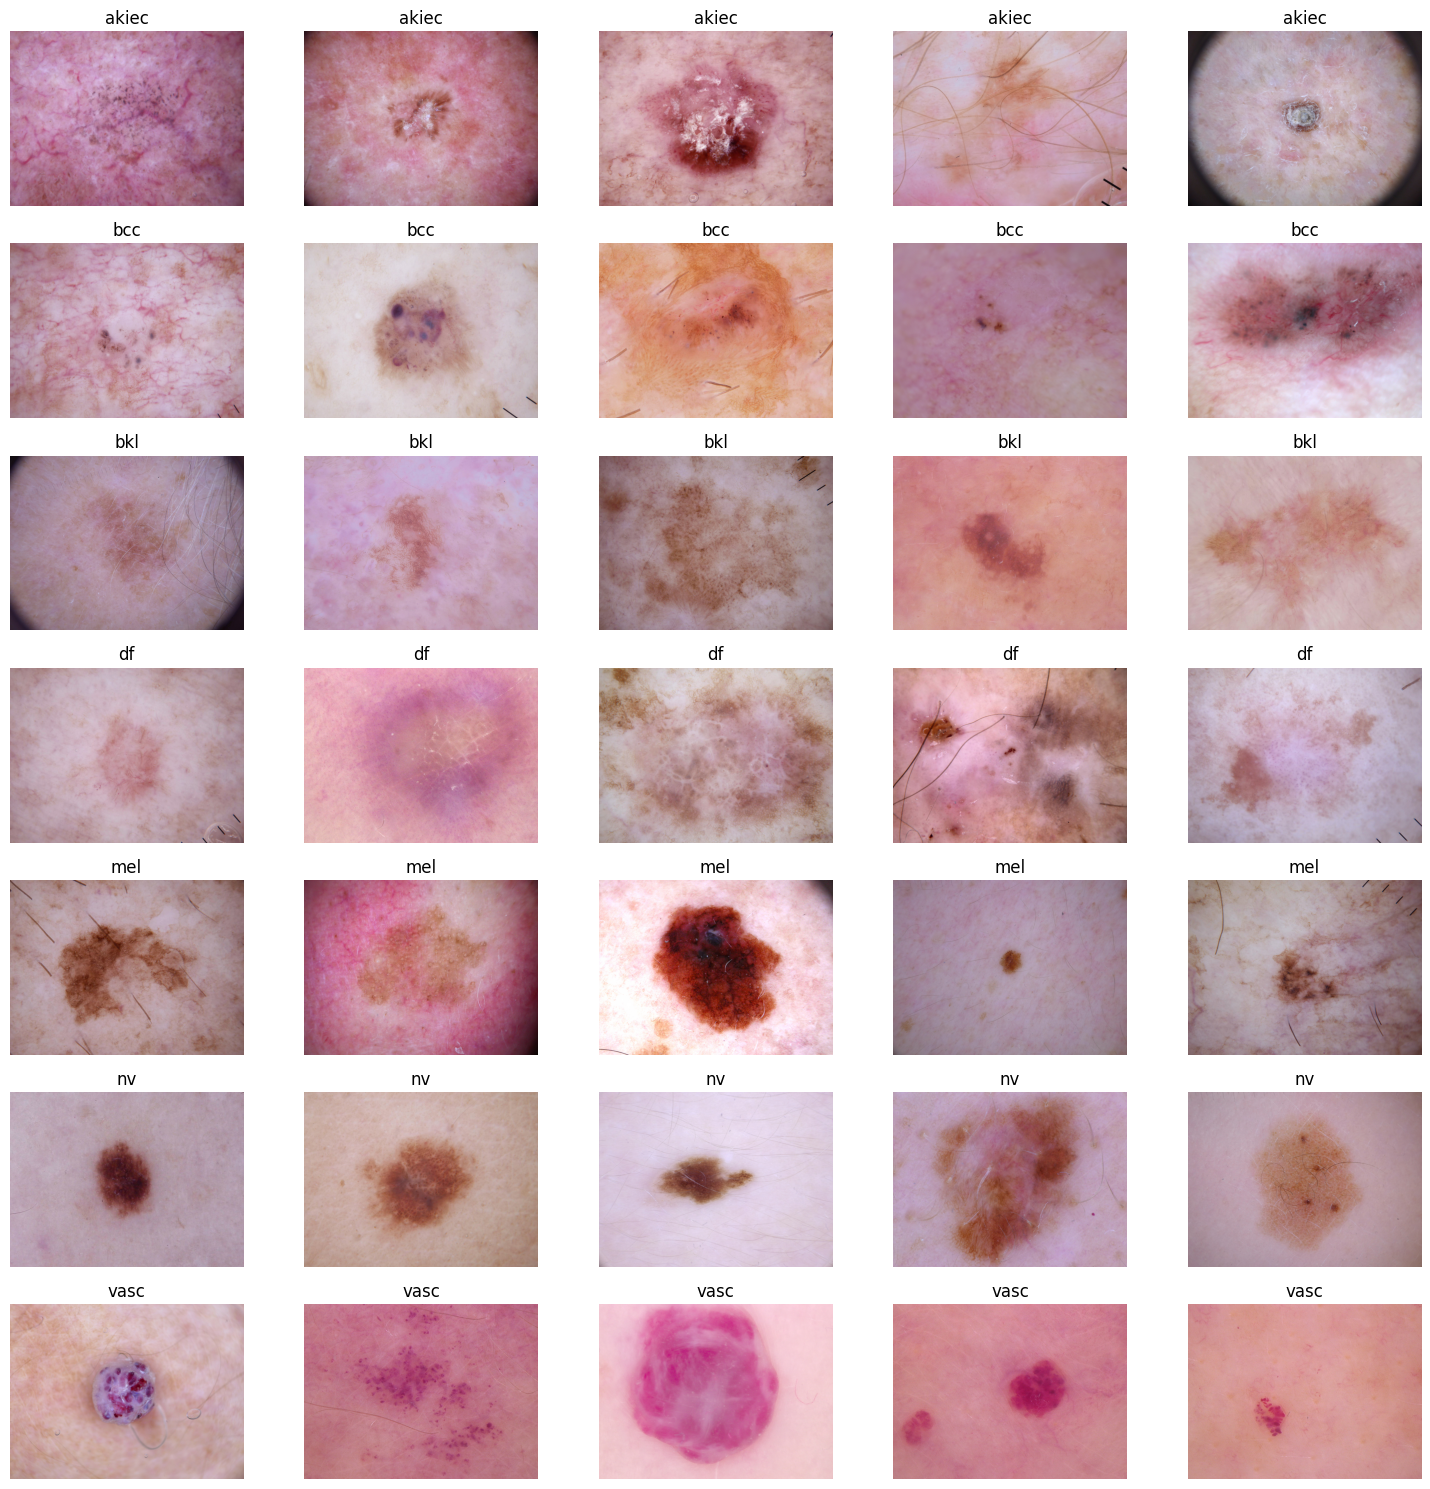

In [62]:
recognized_data_dir = "..\\DATA\\recognized\\" 
diagnoses = os.listdir(data_dir)  
num_examples = 5 

fig, axes = plt.subplots(nrows=len(diagnoses), ncols=num_examples, figsize=(15, 15))

for i, diagnosis in enumerate(diagnoses):
    images = os.listdir(os.path.join(recognized_data_dir, diagnosis))  
    selected_images = random.sample(images, num_examples)  
    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(recognized_data_dir, diagnosis, image_name) 
        img = plt.imread(img_path)  
        axes[i, j].imshow(img)
        axes[i, j].set_title(diagnosis)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [12]:
train_dir = os.path.join(dest_dir, "train")  # create train directory
test_dir = os.path.join(dest_dir, "test")  # create test directory
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [13]:
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["diagnosis"], random_state=42
)  # split images into test and train directories

In [14]:
for index, row in train_df.iterrows():
    source_file = os.path.join(dest_dir, row["diagnosis"], f"{row['image_id']}.jpg")
    destination_file = os.path.join(
        train_dir, row["diagnosis"], f"{row['image_id']}.jpg"
    )
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)
    shutil.copyfile(
        source_file, destination_file
    )  # create subdirectories for each label inside train directory

In [15]:
for index, row in test_df.iterrows():
    source_file = os.path.join(dest_dir, row["diagnosis"], f"{row['image_id']}.jpg")
    destination_file = os.path.join(
        test_dir, row["diagnosis"], f"{row['image_id']}.jpg"
    )
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)
    shutil.copyfile(
        source_file, destination_file
    )  # create subdirectories for each label inside test directory

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="reflect",
)  # define train image generator, add data augmentation techniques

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255.)  # define test image generator

In [18]:
train_data = train_datagen.flow_from_directory(
    directory=train_dir, class_mode="sparse", batch_size=16, target_size=(240, 180)
)  # load train data

Found 4843 images belonging to 7 classes.


In [19]:
test_data = test_datagen.flow_from_directory(
    directory=test_dir, class_mode="sparse", batch_size=16, target_size=(240, 180)
)  # load test_data

Found 1247 images belonging to 7 classes.


In [20]:
memory = Memory(location="./cache")  # define memory cache directory

In [21]:
@memory.cache
def load_images_and_labels(images_data_keras):
    """
    loads images as one dimensional numpy.ndarray of pixels
    and labels (diagnosis) as list of diagnosis
    :param images_data_keras: loaded data though ImageGenerator
    :return: X - numpy.ndarray of pixels; y - list of assigned diagnoses
    """
    X = []
    y = []
    for i in range(len(images_data_keras)):
        images, labels = images_data_keras[i]
        X.extend(images)
        y.extend(labels)
    X = np.array(X)  # change X to np.array
    X = [image.flatten() for image in X]  # change np.ndarray's dimension into one
    X = np.array(X)  # ensure that X is stored as np.array
    return X, y

In [22]:
X_train, y_train = load_images_and_labels(train_data)

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-natal-AppData-Local-Temp-ipykernel-1876427487.load_images_and_labels...
load_images_and_labels(<keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x000001CAA7C40390>)
_________________________________________load_images_and_labels - 127.1s, 2.1min


In [23]:
label_counts = df["diagnosis"].value_counts()

In [24]:
label_map = {
    k: v for k, v in test_data.class_indices.items()
}  # #map numerical labels to string diagnoses

In [26]:
labels_to_augment = label_counts[
    label_counts < 1000
].index.tolist()  # show which labels should be augmented (below 1000)

In [27]:
current_counts = {
    label: len(df[df["diagnosis"] == label]) for label in labels_to_augment
}

In [28]:
current_counts

{'bcc': 514, 'akiec': 327, 'vasc': 142, 'df': 115}

In [29]:
for i, label in enumerate(labels_to_augment):
    labels_to_augment[i] = label_map[label]

In [30]:
keys = current_counts.keys()

In [31]:
current_counts = {label_map[label]: count for label, count in current_counts.items()}

In [32]:
current_counts

{1: 514, 0: 327, 6: 142, 3: 115}

In [33]:
images_to_generate = {
    label: 1000 - current_counts[label] for label in labels_to_augment
}

In [34]:
images_to_generate

{1: 486, 0: 673, 6: 858, 3: 885}

In [35]:
generated_images = []
generated_labels = []

In [36]:
for label in labels_to_augment:
    num_images = images_to_generate[label]
    for _ in range(num_images):
        augmented_batch = next(train_data)
        augmented_images, augmented_labels = augmented_batch

        for l in augmented_labels:
            if l == label:
                generated_images.append(augmented_images[0])
                generated_labels.append(label)

In [37]:
generated_images = np.array(generated_images)
generated_images = [image.flatten() for image in generated_images]
generated_images = np.array(generated_images)

In [38]:
X_train = np.concatenate((X_train, np.array(generated_images)))
y_train = np.concatenate((y_train, np.array(generated_labels)))

In [39]:
X_test, y_test = load_images_and_labels(test_data)

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-natal-AppData-Local-Temp-ipykernel-1876427487.load_images_and_labels...
load_images_and_labels(<keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x000001CAA7C450D0>)
__________________________________________load_images_and_labels - 19.9s, 0.3min


In [40]:
@memory.cache
def scale_train_data(X_train):
    """
    fits and transforms scaler to X_train
    :param X_train: features connected with train data
    :return: scaled X_train and fitted and transformed scaler
    """
    scaler = StandardScaler()  # create scaler instance
    X_train_scaled = scaler.fit_transform(X_train)
    return X_train_scaled, scaler

In [41]:
X_train_scaled, scaler = scale_train_data(X_train)

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-natal-AppData-Local-Temp-ipykernel-2493734789.scale_train_data...
scale_train_data(array([[196.4817 , ..., 161.00285],
       ...,
       [182.17737, ...,  17.6273 ]], dtype=float32))
_______________________________________________scale_train_data - 217.2s, 3.6min


C:\Users\natal\AppData\Local\Temp\ipykernel_5468\2958513691.py:1: UserWarning: Persisting input arguments took 19.44s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X_train_scaled, scaler = scale_train_data(X_train)


In [42]:
@memory.cache
def scale_test_data(X_test, scaler):
    """
    fits and transforms scaler to X_test
    :param X_test: features connected with test data
    :param scaler: scaler instance
    :return: scaled X_test
    """
    X_test_scaled = scaler.transform(X_test)
    return X_test_scaled

In [43]:
X_test_scaled = scale_test_data(X_test, scaler)

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-natal-AppData-Local-Temp-ipykernel-1588998695.scale_test_data...
scale_test_data(array([[160., ..., 143.],
       ...,
       [  0., ...,   0.]], dtype=float32), StandardScaler())
__________________________________________________scale_test_data - 8.1s, 0.1min


C:\Users\natal\AppData\Local\Temp\ipykernel_5468\4211434264.py:1: UserWarning: Persisting input arguments took 1.01s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X_test_scaled = scale_test_data(X_test, scaler)


In [44]:
random_pca = RandomizedPCA(
    whiten=True, random_state=42, svd_solver="randomized", n_components=150
)  # create PCA instance with n_components equal to 150

In [45]:
X_train_pca = random_pca.fit_transform(
    X_train_scaled
)  # fit to X_train in order to choose number of components
X_test_pca = random_pca.transform(X_test_scaled)

In [46]:
random_pca.explained_variance_ratio_.sum()  # explains 95% of variance

0.9455694

In [47]:
pd.DataFrame(X_train_pca).to_csv(
    ".\\DATA\\DataFrames\\X_train_pca.csv", index=False
)  # save X_train_pca
pd.DataFrame(X_test_pca).to_csv(
    ".\\DATA\\DataFrames\\X_test_pca.csv", index=False
)  # save X_test_pca

In [48]:
label_map = {
    v: k for k, v in train_data.class_indices.items()
}  # #map numerical labels to string diagnoses

y_train_diagnosis = [label_map[label] for label in y_train]
y_test_diagnosis = [
    label_map[label] for label in y_test
]  # convert numerical labels to string diagnoses for y_train and y_test

y_train_diagnosis_df = pd.DataFrame(y_train_diagnosis, columns=["diagnosis"])
y_test_diagnosis_df = pd.DataFrame(y_test_diagnosis, columns=["diagnosis"])

y_train_diagnosis_df.to_csv(".\\DATA\\DataFrames\\y_train_diagnosis.csv", index=False)
y_test_diagnosis_df.to_csv(".\\DATA\\DataFrames\\y_test_diagnosis.csv", index=False)